# **Import Module**

In [1]:
# Import Library
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

**dataset path**

In [2]:
# Dataset Path
dataset_path = '/kaggle/input/covid-pneumonia-normal-chest-xray-images/'

# **Explorasi Dataset**

# 1. Melihat struktur dan banyak data

In [3]:
# Fungsi untuk menghitung jumlah gambar dalam setiap folder
def count_images_per_folder(path):
    folder_counts = {}
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        if os.path.isdir(folder_path):
            num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
            folder_counts[folder_name] = num_images
    return folder_counts

# Hitung jumlah gambar per folder
folder_counts = count_images_per_folder(dataset_path)
print("Jumlah gambar per folder:")
for folder, count in folder_counts.items():
    print(f"{folder}: {count}")

Jumlah gambar per folder:
PNEUMONIA: 1800
NORMAL: 1802
COVID: 1626


# 2. Visualisasi Distribusi per Kelas

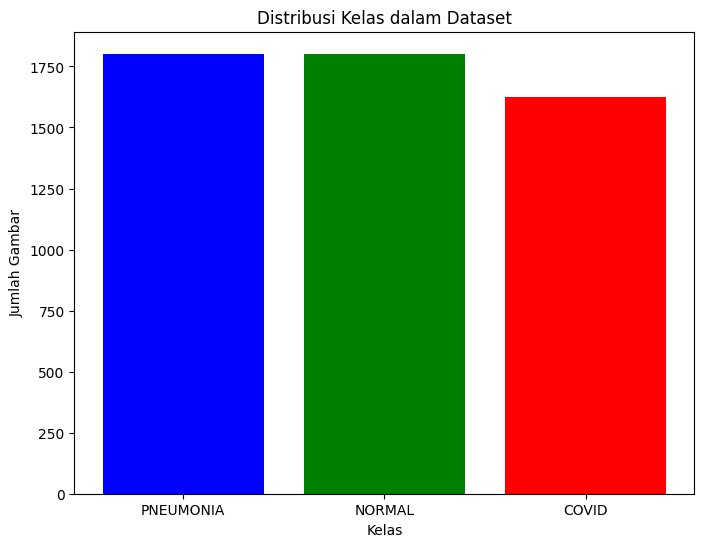

In [4]:
# Visualisasi distribusi kelas dalam bar chart
plt.figure(figsize=(8, 6))
plt.bar(folder_counts.keys(), folder_counts.values(), color=['blue', 'green', 'red'])
plt.title("Distribusi Kelas dalam Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

# 3. Menampilkan Gambar per Kelas

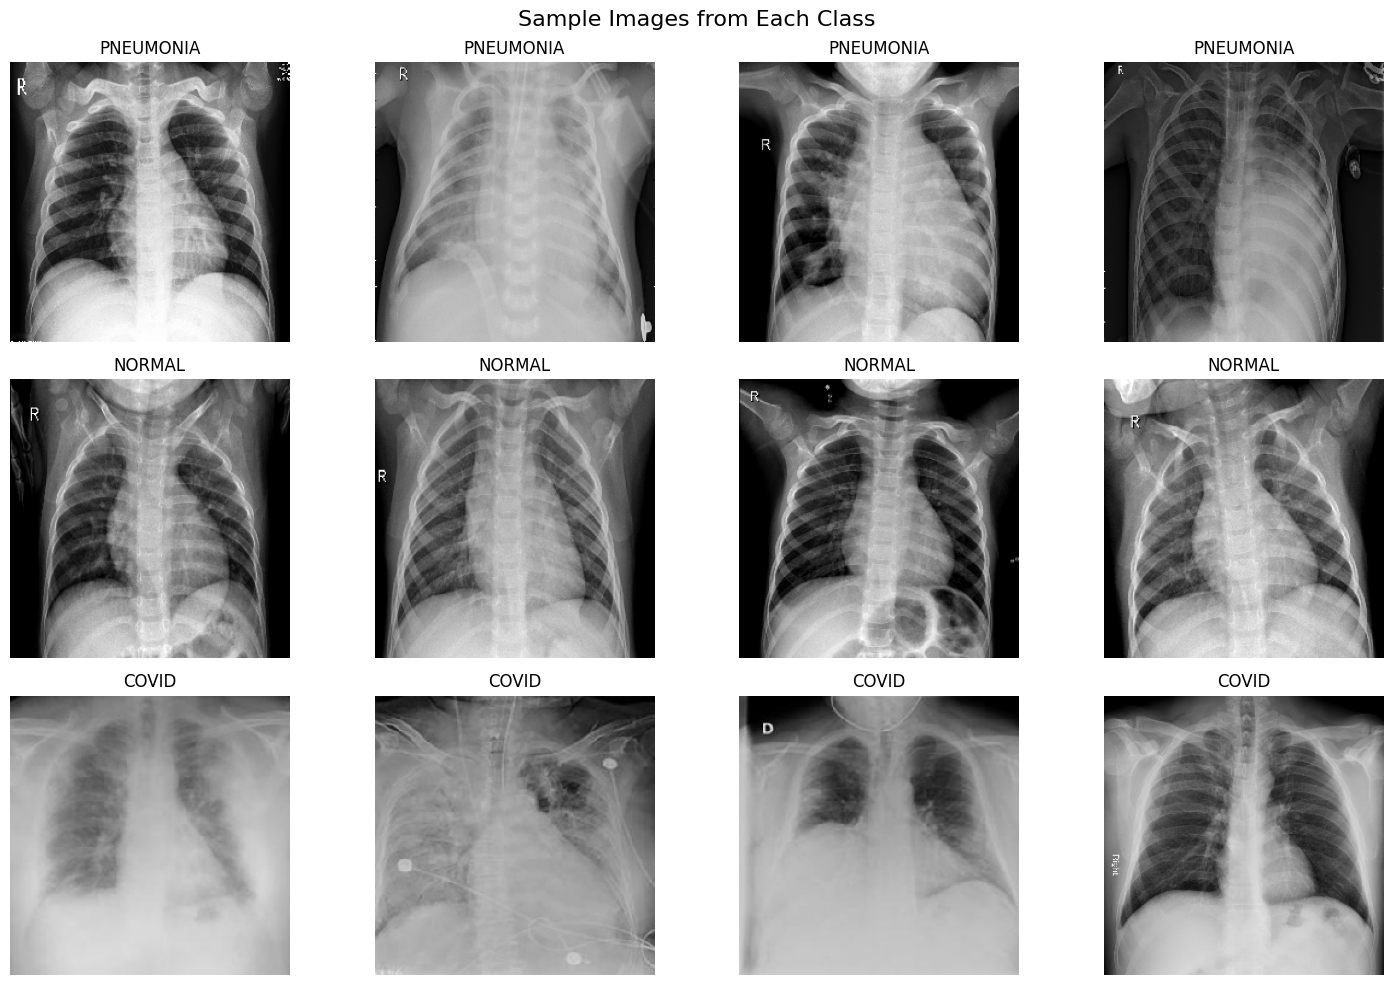

In [5]:
# Fungsi untuk menampilkan beberapa contoh gambar per folder
def show_sample_images(path, num_samples=4):
    fig, axes = plt.subplots(len(os.listdir(path)), num_samples, figsize=(15, 10))
    fig.suptitle("Sample Images from Each Class", fontsize=16)
    
    for i, folder_name in enumerate(os.listdir(path)):
        folder_path = os.path.join(path, folder_name)
        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
            sample_files = random.sample(image_files, min(num_samples, len(image_files)))
            
            for j, image_file in enumerate(sample_files):
                image_path = os.path.join(folder_path, image_file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f"{folder_name}")
    
    plt.tight_layout()
    plt.show()

# Menampilkan contoh gambar
show_sample_images(dataset_path, num_samples=4)

# **Data Preparation**

# 1. Resizing

In [6]:
# Data Preparation
img_size = (224, 224)
batch_size = 32

# 2. Data Augmentation for Training Set

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# 3. Data Augmentation fo Validation Set

In [8]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# 4. Load Training Data

In [9]:
# Load Training Data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 4183 images belonging to 3 classes.


# 5. Load Validation Data

In [10]:
# Load Validation Data
validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1045 images belonging to 3 classes.


# **Model Implementation**

# 1. Parameters

In [11]:
# Parameters
epochs = 50

# 2. Load Pretrained Model

In [15]:
# Load Pretrained MobileNetV2
input_tensor = Input(shape=(224, 224, 3))  # Dimensi harus jelas
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


# Freeze base model
base_model.trainable = False

<ipython-input-15-466c5a6eec1b>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


# 3. Build Model

In [16]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


# 4. Callback

In [18]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('mobilenetv2_best_model.keras', save_best_only=True, monitor='val_loss')


# 5. Train Model

In [19]:
# Train Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 718ms/step - accuracy: 0.5502 - loss: 1.0208 - val_accuracy: 0.8612 - val_loss: 0.3753 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 54s 391ms/step - accuracy: 0.8573 - loss: 0.3802 - val_accuracy: 0.9043 - val_loss: 0.2773 - learning_rate: 1.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 385ms/step - accuracy: 0.8939 - loss: 0.2999 - val_accuracy: 0.9100 - val_loss: 0.2448 - learning_rate: 1.0000e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 405ms/step - accuracy: 0.9115 - loss: 0.2631 - val_accuracy: 0.8967 - val_loss: 0.2619 - learning_rate: 1.0000e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 415ms/step - accuracy: 0.9197 - loss: 0.2340 - val_accuracy: 0.9234 - val_loss: 0.2022 - learning_rate: 1.0000e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 426ms/step - accuracy: 0.9135 - loss: 0.2377 - val_accuracy: 0.9282 - val_loss: 0.1837 - learning_rate: 1.0000e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 422ms/step -

# **Evaluation**

# 1. Accuracy Plot

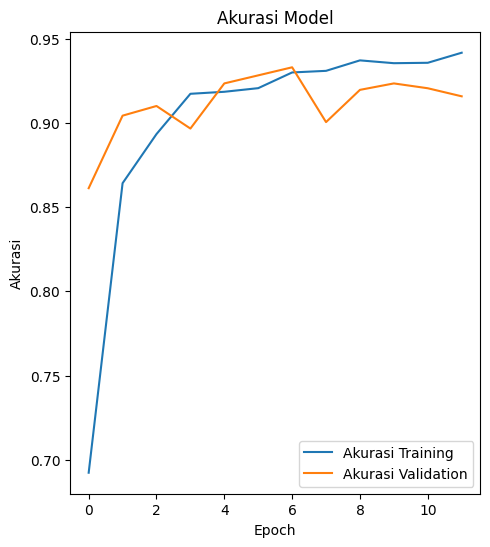

In [20]:
plt.figure(figsize=(18, 6))

# Plot akurasi training dan validation
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.show()

# 2. Loss Plot

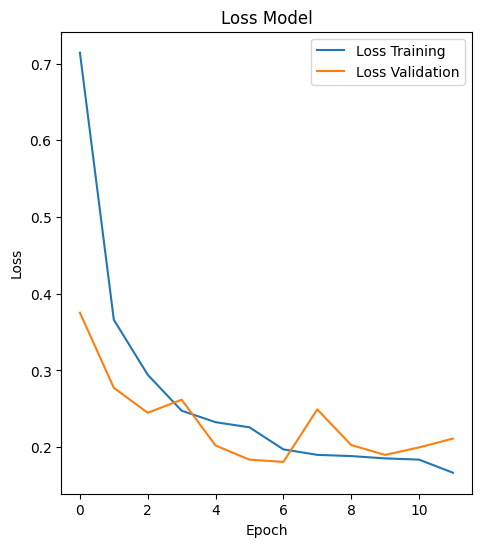

In [21]:
plt.figure(figsize=(18, 6))

# Plot loss training dan validation
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 3. Total Accuracy

In [23]:
# Evaluation
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Loss pada data validasi: {val_loss:.4f}")
print(f"Akurasi pada data validasi: {val_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9488 - loss: 0.1516
Loss pada data validasi: 0.1808
Akurasi pada data validasi: 0.9330


# 4. Best Result

In [26]:
# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Loss pada data validasi: {val_loss:.4f}")
print(f"Akurasi pada data validasi: {val_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9481 - loss: 0.1533
Loss pada data validasi: 0.1808
Akurasi pada data validasi: 0.9330


# **Model Save**

In [25]:
# Save Model
model_path = 'mobilenetv2_final_model.keras'
model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at mobilenetv2_final_model.keras
